In [36]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [37]:
DATASET_PATH = 'small_birds_dataset/train/'

data_dir = pathlib.Path(DATASET_PATH)

In [38]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['azaspi1' 'chcant2' 'houspa' 'redcro' 'wbwwre1']


In [39]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=320000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 241 files belonging to 5 classes.
Using 193 files for training.
Using 48 files for validation.

label names: ['azaspi1' 'chcant2' 'houspa' 'redcro' 'wbwwre1']


In [40]:
train_ds.element_spec

(TensorSpec(shape=(None, 320000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [41]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [42]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [43]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 320000)
(64,)


In [44]:
label_names[[1,1,3,0]]

array(['chcant2', 'chcant2', 'redcro', 'azaspi1'], dtype='<U7')

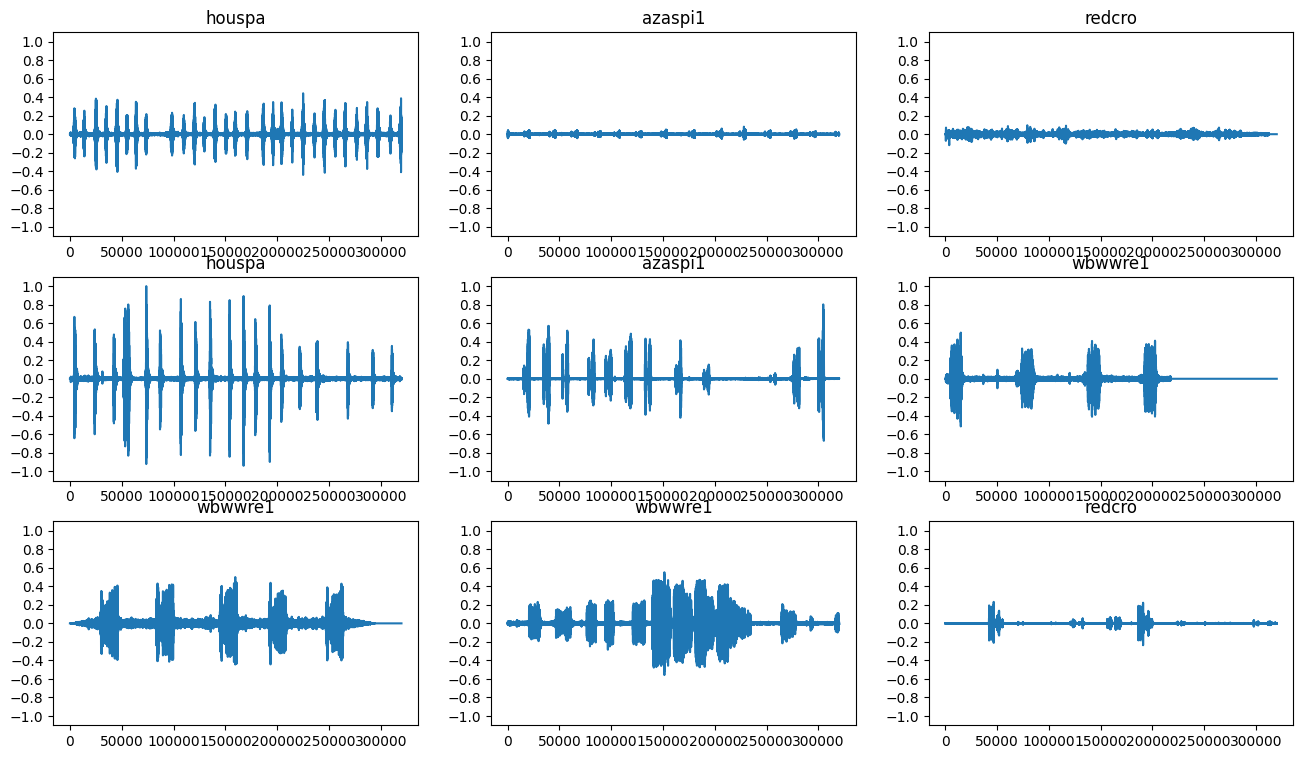

In [45]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [46]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [47]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: houspa
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


Label: azaspi1
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


Label: redcro
Waveform shape: (320000,)
Spectrogram shape: (2499, 129, 1)
Audio playback


In [48]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

C:\Users\Youss\AppData\Local\Temp\ipykernel_16692\3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


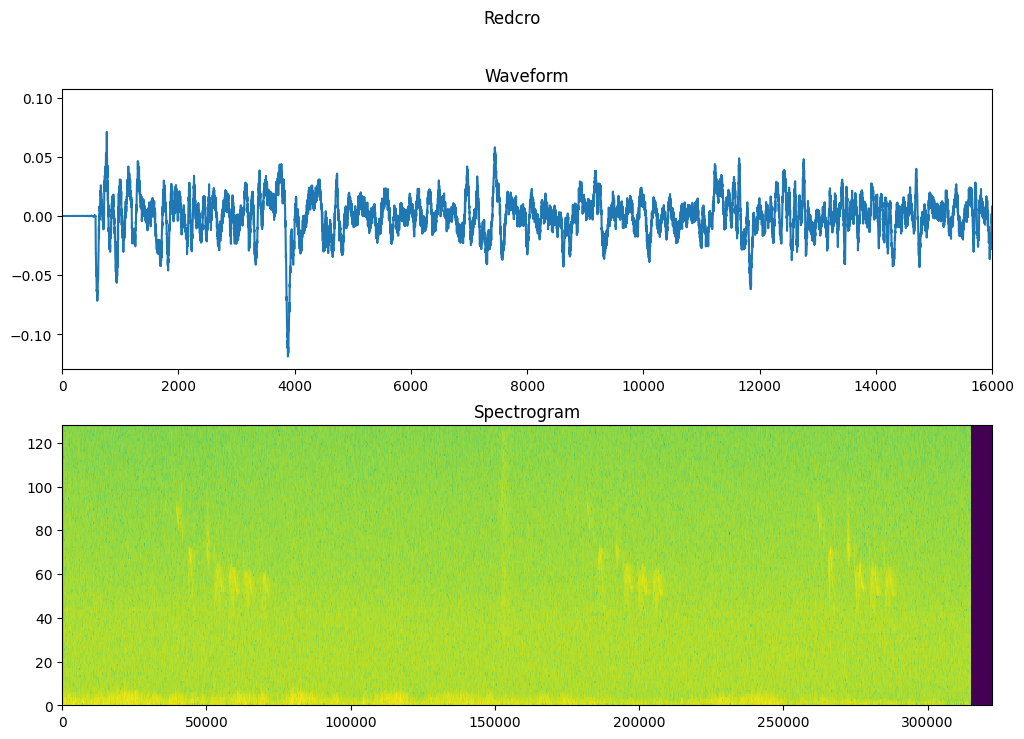

In [49]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [50]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [51]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [52]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

C:\Users\Youss\AppData\Local\Temp\ipykernel_16692\3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


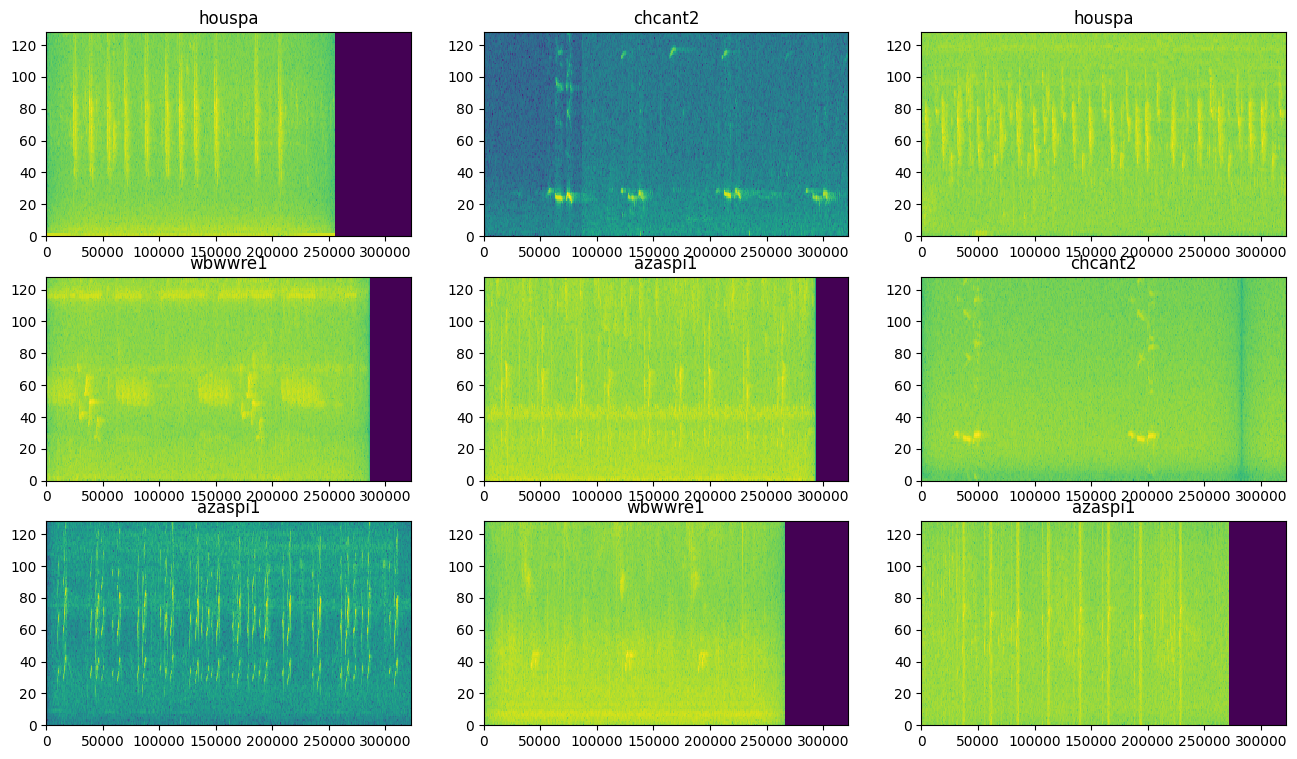

In [53]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [54]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [55]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (2499, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)      

In [56]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [73]:
EPOCHS = 30

filepath = "./sound_model_{epoch:02d}-{val_accuracy:.2f}.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0183 - accuracy: 1.0000

4/4 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 99ms/step - loss: 0.0111 - accuracy: 1.0000
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9948WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 97ms/step - loss: 0.0385 - accuracy: 0.9948
Epoch 3/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 93ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9948WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 92ms/step - loss: 0.0120 - accuracy: 0.9948
Epoch 5/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0298 - accuracy: 0.9896WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 96ms/step - loss: 0.0297 - accuracy: 0.9896
Epoch 6/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 94ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 7/30
4/4 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 106ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 8/30
4/4 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 118ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 9/30
4/4 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 91ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 10/30
4/4 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9948WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 93ms/step - loss: 0.0096 - accuracy: 0.9948
Epoch 11/30
4/4 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9896  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 94ms/step - loss: 0.0160 - accuracy: 0.9896
Epoch 12/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0108 - accuracy: 0.9948WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 102ms/step - loss: 0.0107 - accuracy: 0.9948
Epoch 13/30
4/4 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 110ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 14/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 93ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 15/30
4/4 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 92ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 16/30
4/4 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 93ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 17/30
4/4 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9948  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 93ms/step - loss: 0.0415 - accuracy: 0.9948
Epoch 18/30
4/4 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9948WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 128ms/step - loss: 0.0078 - accuracy: 0.9948
Epoch 19/30
4/4 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 98ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 20/30
4/4 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 103ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 21/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 93ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 22/30
4/4 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 115ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 23/30
4/4 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 115ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 24/30
4/4 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9948  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 92ms/step - loss: 0.0448 - accuracy: 0.9948
Epoch 25/30
4/4 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 100ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 26/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 93ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 27/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 99ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 28/30
3/4 [=====================>........] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 102ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 29/30
4/4 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9948WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 95ms/step - loss: 0.0373 - accuracy: 0.9948
Epoch 30/30
4/4 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


4/4 [==============================] - 0s 99ms/step - loss: 0.0044 - accuracy: 1.0000


In [58]:
'''metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')'''

"metrics = history.history\nplt.figure(figsize=(16,6))\nplt.subplot(1,2,1)\nplt.plot(history.epoch, metrics['loss'], metrics['val_loss'])\nplt.legend(['loss', 'val_loss'])\nplt.ylim([0, max(plt.ylim())])\nplt.xlabel('Epoch')\nplt.ylabel('Loss [CrossEntropy]')\n\nplt.subplot(1,2,2)\nplt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))\nplt.legend(['accuracy', 'val_accuracy'])\nplt.ylim([0, 100])\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy [%]')"

In [72]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 25ms/step - loss: 4.4856 - accuracy: 0.5833


{'loss': 4.485635280609131, 'accuracy': 0.5833333134651184}

In [60]:
y_pred = model.predict(test_spectrogram_ds)


1/1 [==============================] - 0s 91ms/step


In [61]:
y_pred = tf.argmax(y_pred, axis=1)

In [62]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

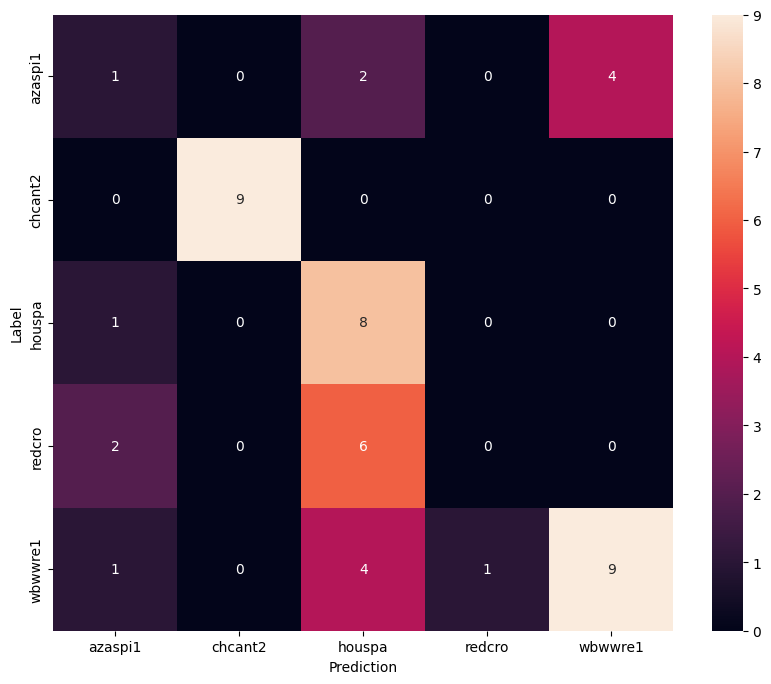

In [63]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

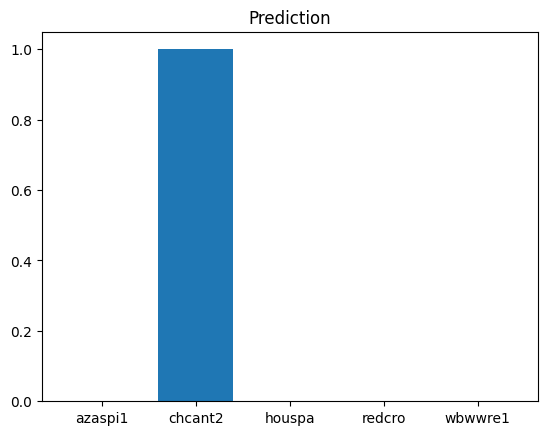

In [64]:
x = 'small_bird_dataset_2/test/chcant2/XC7221.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=320000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['azaspi1', 'chcant2', 'houspa', 'redcro', 'wbwwre1']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Prediction')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [65]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 32000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=320000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [66]:
export = ExportModel(model)
export(tf.constant(str('small_bird_dataset_2/test/chcant2/XC7221.wav')))

{'predictions': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.02310113, 12.978264  , -3.63151   , -6.164153  ,  0.58804274]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'chcant2'], dtype=object)>}

In [67]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'predictions': <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.02310113, 12.978264  , -3.63151   , -6.164153  ,  0.58804274]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'chcant2'], dtype=object)>}